### 2020/7/17のTMEIC打ち合わせのためのデモ実験

In [1]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
# No = (os.path.basename(__file__))[-4]
No = "0" # notebook用
print('実験No.'+No)
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
import matplotlib.pyplot as plt
import plotly
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
# 人工データを生成してくれる機械が置いてあるところ
import tsModel

実験No.0


### 学習データの作成

In [2]:
# 真のモデルのパラメータ
phi_ast= [0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p_ast=len(phi_ast)
mu_ast=0
sigma_ast=1
trainN = 1000

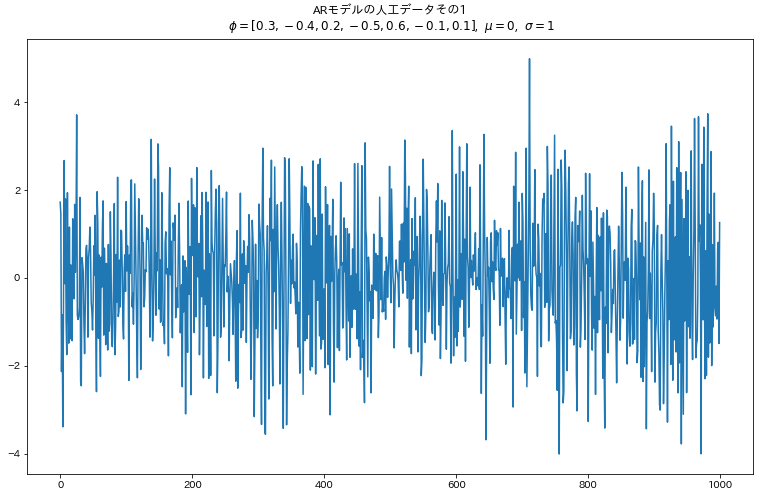

In [3]:
# 人工データの作成
seed=1
phi = phi_ast
Data = tsModel.SARIMA(a=phi, N=trainN, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
innovation = tsModel.SARIMA(a=phi, N=trainN, random_seed=seed, mu=mu_ast, sigma=sigma_ast, return_innovation=True)
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
plt.title("ARモデルの人工データその{0}".format(seed) +"\n $\phi="+str(phi)+"$,  $\mu="+str(mu_ast)+"$,  $\sigma="+str(sigma_ast)+"$")
plt.savefig("../images/AR7モデルの人工データその{0}.png".format(seed))

### 学習データを用いてパラメータを最尤推定

In [4]:
q = 2

In [5]:
# 最尤推定で学習
# モデルの生成
model = sm.tsa.AR(Data)
# 推定
result = model.fit(maxlag=q)

In [6]:
# パラメータの推定結果
phi_hat = result.params[1:]
mu_hat = result.params[0]
sigma2_hat = result.sigma2
print(phi_hat)
print(mu_hat)
print(sigma2_hat)

[ 0.00785898 -0.2330914 ]
0.04234144377770396
1.8901661629803435


### テストデータの作成

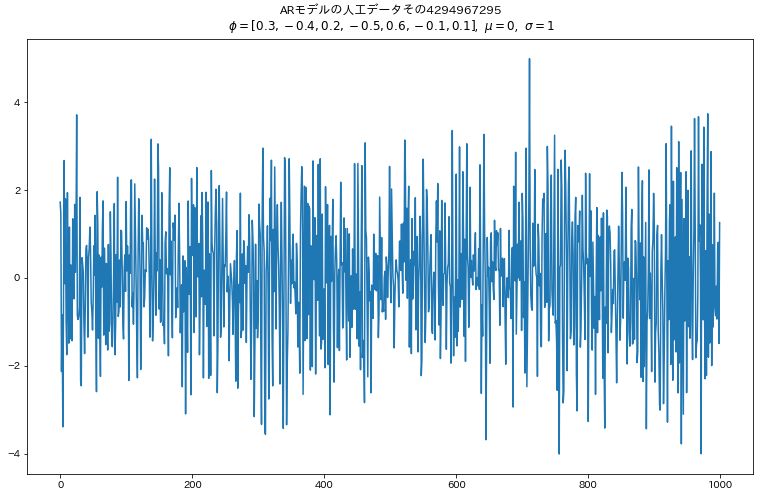

In [7]:
seed=2**32 - 1
phi = phi_ast
testData = tsModel.SARIMA(a=phi, N=trainN, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
testinnovation = tsModel.SARIMA(a=phi, N=trainN, random_seed=seed, mu=mu_ast, sigma=sigma_ast, return_innovation=True)
# Data = torch.tensor(Data, dtype=torch.float)
# Data = torch.tensor(Data)
plt.figure(figsize=(13,8))
plt.plot(Data)
plt.title("ARモデルの人工データその{0}".format(seed) +"\n $\phi="+str(phi)+"$,  $\mu="+str(mu_ast)+"$,  $\sigma="+str(sigma_ast)+"$")
plt.savefig("../images/AR7モデルの人工データその{0}.png".format(seed))

In [17]:
i=7
testData[i-q:i].shape[0]==q

False

In [18]:
inno_hat=[]
Xs_hat=[]
for i in range(len(testData)):
    if not testData[i-q:i].shape[0]==q:
        Xs_hat.append(None)
        inno_hat.append(None)
    else:
        hat_X = (phi_hat*np.flip(testData[i-q:i])).sum()+mu_hat
        Xs_hat.append(hat_X)
        inno_hat.append(testData[i]-hat_X)

In [19]:
len(inno_hat)

1000

In [23]:
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=list(range(len(testData))), y=testData, name="テストデータ", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(len(testinnovation))), y=testinnovation, name="真のinnovation", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(len(inno_hat))), y=inno_hat, name="推定したinnovation", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="ARモデルの人工データその{0}".format(seed),
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,1000]},
                yaxis={"title":"value"},
                width = 1000,       # 全体のサイズ
                height = 400,
                )
)
plotly.offline.iplot(fig)

In [28]:
fig = plotly.graph_objs.Figure(
    data=[
          plotly.graph_objs.Scatter(x=list(range(len(testinnovation))), y=testinnovation, name="真のinno", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(len(inno_hat))), y=inno_hat, name="推定inno", yaxis='y'),
          plotly.graph_objs.Scatter(x=list(range(len(testData))), y=testData, name="データ", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="テストデータにおけるinnovation推定量の系列と真のinnovationの系列",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 1500,       # 全体のサイズ
                height = 500,
                )
)
plotly.offline.iplot(fig)

In [12]:
((testinnovation[q:] - np.array(inno_hat)[q:])**2).mean()

0.9494639651936996

### qを１〜１０で動かしてinnovationの平均二乗誤差を比較する

In [13]:
mse = []

for q in range(1,11):
    # 最尤推定で学習
    # モデルの生成
    model = sm.tsa.AR(Data)
    # 推定
    result = model.fit(maxlag=q)
    # パラメータの推定結果
    phi_hat = result.params[1:]
    mu_hat = result.params[0]
    sigma2_hat = result.sigma2
    inno_hat=[]
    Xs_hat=[]
    for i in range(len(testData)):
        if not testData[i-q:i].shape[0]==q:
            Xs_hat.append(None)
            inno_hat.append(None)
        else:
            hat_X = (phi_hat*np.flip(testData[i-q:i])).sum()+mu_hat
            Xs_hat.append(hat_X)
            inno_hat.append(testData[i]-hat_X)

    mse.append(((testinnovation[q:] - np.array(inno_hat)[q:])**2).mean())

In [14]:
mse.index(min(mse))

7

In [15]:
range(1, 11)

range(1, 11)

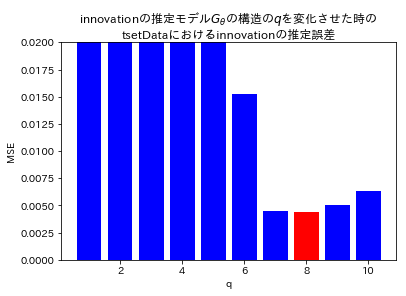

In [16]:
color = ["blue"]*11
color[mse.index(min(mse))]="red"    
plt.bar(x=range(1, 11), height=mse, color=color)
plt.xlabel("q")
plt.ylabel("MSE")
plt.ylim(0,0.02)
plt.title("innovationの推定モデル$G_{\\theta}$の構造の$q$を変化させた時の\ntsetDataにおけるinnovationの推定誤差")
plt.savefig("barplot.png")